### Load all decisoes

In [82]:
from os import listdir
from os.path import isfile, join

pdfs_path = 'output/stj-decisoes'

pdf_files = [f for f in listdir(pdfs_path) if isfile(join(pdfs_path, f)) and f.lower().endswith('.pdf')]

print('index=decisao')
for idx, pf in enumerate(pdf_files):
    print(str(idx) + '=' + pf)
    
print('Found ' + str(len(pdf_files)) + ' pdf files (decisoes)')

index=decisao
0=decisao-84181384.pdf
1=decisao-84181192.pdf
2=decisao-84181794.pdf
3=decisao-84181227.pdf
4=decisao-84181541.pdf
5=decisao-84171665.pdf
6=decisao-84181582.pdf
7=decisao-84181756.pdf
8=decisao-84171506.pdf
9=decisao-84181811.pdf
10=decisao-84181150.pdf
11=decisao-84181178.pdf
12=decisao-84171458.pdf
13=decisao-84181230.pdf
14=decisao-84181580.pdf
15=decisao-84181231.pdf
16=decisao-84181796.pdf
17=decisao-84181184.pdf
18=decisao-84181621.pdf
19=decisao-84181635.pdf
20=decisao-84181386.pdf
21=decisao-84181437.pdf
22=decisao-84181427.pdf
23=decisao-84171703.pdf
24=decisao-84181194.pdf
25=decisao-84181180.pdf
26=decisao-84181786.pdf
27=decisao-84181553.pdf
28=decisao-84171663.pdf
29=decisao-84181585.pdf
30=decisao-84181234.pdf
31=decisao-84181793.pdf
32=decisao-84181181.pdf
33=decisao-84181156.pdf
34=decisao-84181381.pdf
35=decisao-84181168.pdf
36=decisao-84181752.pdf
37=decisao-84181949.pdf
38=decisao-84171674.pdf
39=decisao-84171675.pdf
40=decisao-84181579.pdf
41=decisao-8

In [83]:
import modules.nlputils as nlputils
import sys

print('Loading text from pdfs')
decisoes = []
for f in pdf_files:
    text = nlputils.pdf_text_extract(pdfs_path + '/' + f)
    decisoes.append(text)
    sys.stdout.write('.')

print('\nSAMPLE TEXT EXTRACTED FROM PDF')
print(decisoes[1])

Loading text from pdfs
................................................................................................................................................................
SAMPLE TEXT EXTRACTED FROM PDF
AgInt no AGRAVO EM RECURSO ESPECIAL Nº 1.149.872 - MG (2017/0197203-6)  AGRAVANTE :MUNICÍPIO DE BELO HORIZONTE PROCURADOR:LUIZ FELIPE FERREIRA GOMES SILVA E OUTRO(S) - MG110376 AGRAVADO  :JANICE OLIVEIRA DINIZ ADVOGADO:EDUARDO MACHADO DIAS E OUTRO(S) - MG074384 RELATÓRIOO SR. MINISTRO OG FERNANDES: Trata-se de agravo interno manejado por Município de Belo Horizonte contra decisão que não conheceu do agravo em recurso especial.O agravante aduz não ser caso de aplicação da Súmula 182/STJ, porquanto houve o efetivo combate dos fundamentos do decisum pelo qual foi negado seguimento ao recurso especial.É o relatório. Documento: 84181192 - RELATÓRIO E VOTO - Site certificado Página  1 de 3AgInt no AGRAVO EM RECURSO ESPECIAL Nº 1.149.872 - MG (2017/0197203-6)  VOTOO SR. MINISTRO OG

### Find similar contents (brute force NxN)

In [84]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

vec = TfidfVectorizer(min_df=0.1, analyzer='word', ngram_range=(1, 2))

def cos_similarity(textlist):
    tfidf = vec.fit_transform(textlist)
    return (tfidf * tfidf.T).toarray()

similarity_matrix = cos_similarity(decisoes)
print(similarity_matrix)

[[ 1.          0.37902841  0.28335649 ...,  0.45598772  0.25664114
   0.46903886]
 [ 0.37902841  1.          0.28629098 ...,  0.50681266  0.32368417
   0.50909688]
 [ 0.28335649  0.28629098  1.         ...,  0.39542638  0.20564189
   0.35724886]
 ..., 
 [ 0.45598772  0.50681266  0.39542638 ...,  1.          0.29881358
   0.60717656]
 [ 0.25664114  0.32368417  0.20564189 ...,  0.29881358  1.          0.33452153]
 [ 0.46903886  0.50909688  0.35724886 ...,  0.60717656  0.33452153  1.        ]]


In [96]:
for a in range(len(similarity_matrix)):
    for b in range(len(similarity_matrix[a])):
        v = similarity_matrix[a][b]
        if v>0.9 and a!=b:
            print(pdf_files[a] + ' ~= ' + pdf_files[b] + ': ' + str(v))


decisao-84181178.pdf ~= decisao-84181427.pdf: 0.959187869952
decisao-84181178.pdf ~= decisao-84181585.pdf: 0.970153322861
decisao-84181178.pdf ~= decisao-84181876.pdf: 0.96868519361
decisao-84181178.pdf ~= decisao-84181229.pdf: 0.971305867143
decisao-84181427.pdf ~= decisao-84181178.pdf: 0.959187869952
decisao-84181427.pdf ~= decisao-84181585.pdf: 0.979825790235
decisao-84181427.pdf ~= decisao-84181876.pdf: 0.976108898821
decisao-84181427.pdf ~= decisao-84181229.pdf: 0.956269186908
decisao-84181786.pdf ~= decisao-84181413.pdf: 0.902994153032
decisao-84181585.pdf ~= decisao-84181178.pdf: 0.970153322861
decisao-84181585.pdf ~= decisao-84181427.pdf: 0.979825790235
decisao-84181585.pdf ~= decisao-84181876.pdf: 0.988547556413
decisao-84181585.pdf ~= decisao-84181229.pdf: 0.966547236626
decisao-84181668.pdf ~= decisao-84181655.pdf: 0.970650211788
decisao-84181668.pdf ~= decisao-84181656.pdf: 0.947829042521
decisao-84181668.pdf ~= decisao-84181675.pdf: 0.96225823787
decisao-84181668.pdf ~= de

### Clusterize decisoes

In [26]:
from modules.nlputils import StemFilterTokenizeProcessor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import pandas as pd

stopwords = set([line.strip() for line in open('stopwords.txt', 'r', encoding='utf-8')])
proc = StemFilterTokenizeProcessor(min_size=3, filter_regex='[a-z]', stem_language='portuguese', stem_complete=True, only_nouns=True)

vec = TfidfVectorizer(min_df=0.1, stop_words=stopwords, analyzer='word', ngram_range=(1, 2), preprocessor=proc.process_text)
X = vec.fit_transform(decisoes)

number_of_clusters = 5
kmeans_model = KMeans(n_clusters=number_of_clusters)
decisoes_groups = kmeans_model.fit_predict(X)

order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
terms = vec.get_feature_names()
cluster_labels = []
for i in range(number_of_clusters):
    top_words = [terms[ind] for ind in order_centroids[i, :5]]
    gl = "Cluster {}: {}".format(i, ' '.join(top_words))
    cluster_labels.append(gl)
    
pd.DataFrame(cluster_labels).head()

,0
0,Cluster 0: concessão execução decreto recurso ...
1,Cluster 1: recurso agravo decisão tribunal des...
2,Cluster 2: recursos agravo decisão agravo recu...
3,Cluster 3: ministro agravo recurso ministro re...
4,Cluster 4: manifestação tribunal regimento tri...


In [30]:
results = pd.DataFrame()
results['decisoes'] = decisoes
results['cluster'] = kmeans_model.labels_
results.head()

,decisoes,cluster
0,AgInt no AGRAVO EM RECURSO ESPECIAL Nº 1.149.8...,1
1,RECURSO ESPECIAL Nº 1.526.125 - SP (2015/00749...,1
2,AGRAVO EM RECURSO ESPECIAL Nº 1.270.458 - RS (...,1
3,HABEAS CORPUS Nº 445.124 - PI (2018/0083233-1)...,4
4,RECURSO EM HABEAS CORPUS Nº 98.329 - AL (2018/...,1


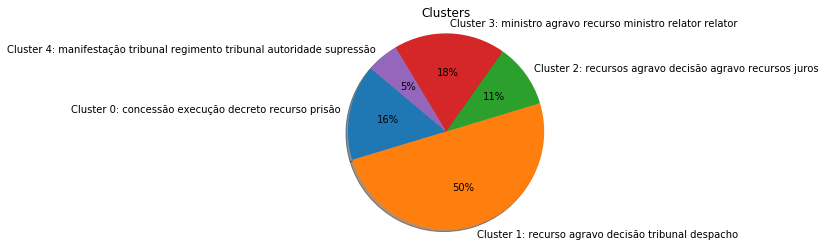

In [31]:
import matplotlib.pyplot as plt
s = results.groupby(['cluster']).size()
s = tuple(zip(s,s.index))
plt.title('Clusters')
plt.pie([x[0] for x in s],
        labels=cluster_labels,
        autopct='%1.0f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()

In [32]:
for index, row in results[:5].iterrows():
    print('========')
    print(str(row['cluster']) + ' ' + cluster_labels[row['cluster']] + ' ' + row['decisoes'])

1 Cluster 1: recurso agravo decisão tribunal despacho AgInt no AGRAVO EM RECURSO ESPECIAL Nº 1.149.872 - MG (2017/0197203-6)  AGRAVANTE :MUNICÍPIO DE BELO HORIZONTE PROCURADOR:LUIZ FELIPE FERREIRA GOMES SILVA E OUTRO(S) - MG110376 AGRAVADO  :JANICE OLIVEIRA DINIZ ADVOGADO:EDUARDO MACHADO DIAS E OUTRO(S) - MG074384 RELATÓRIOO SR. MINISTRO OG FERNANDES: Trata-se de agravo interno manejado por Município de Belo Horizonte contra decisão que não conheceu do agravo em recurso especial.O agravante aduz não ser caso de aplicação da Súmula 182/STJ, porquanto houve o efetivo combate dos fundamentos do decisum pelo qual foi negado seguimento ao recurso especial.É o relatório. Documento: 84181192 - RELATÓRIO E VOTO - Site certificado Página  1 de 3AgInt no AGRAVO EM RECURSO ESPECIAL Nº 1.149.872 - MG (2017/0197203-6)  VOTOO SR. MINISTRO OG FERNANDES (Relator): A decisão impugnada deve ser mantida.A Corte de origem negou seguimento ao recurso especial com base no óbice disposto na Súmula 83/STJ.O a